In [2]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import nltk
from sklearn.model_selection import KFold ,StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score ,cross_val_predict
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer ,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline




#  La Collecte des données

In [3]:
def create_dataset(textes , target ) :
    dic = { "texte" : [] , "target" :[]}
    for (i ,classe) in zip(textes ,target)  :
#         lire les fichier textes 
        with open(i , encoding = 'utf-8') as f :
            
            text = f.read()
#         remplacer les séparateur par *
            text = re.sub("[-]+\d+[-]+" , "*" , text)
        s = ""
        
#         associer à chaque article sa classe
        for i in text :
            if i != "*" :
                s += i
            else :
                if s not in dic['texte'] :
                    dic['texte'].append(s)
                    dic['target'].append(classe)
                    
                    s=""
                continue
        
                
            
    return dic   
            
            

In [46]:
dic = create_dataset(["20 articles ecomonie (1).txt" ,"28 articles politique.txt" ,"28 articles société.txt"  ,"29 articles sport.txt","36 articles culture.txt"],["economie" ,"politique","societe","sport" ,"culture"])

texte = dic["texte"]
classe = dic["target"]

dic = { "texte" : [] , "target" :[]}
for (i,j) in zip(texte,classe):
    phrases = i.split(".")
    classe = j
    for j in phrases :
        dic["texte"].append(j)
        dic["target"].append(classe)
    

In [47]:
df = pd.DataFrame(dic)
df

,texte,target
0,"Renault Group et Managem Group ont scellé, mer...",economie
1,\n\nS’inscrivant dans le cadre d’un partenaria...,economie
2,000 tonnes de sulfate de cobalt par an pendant...,economie
3,"\n\nEn vertu de cette alliance, les deux group...",economie
4,"\n\nAinsi, Renault Group s’assurera d’un appro...",economie
...,...,...
2063,"Les Gnaoua créent des passerelles, nous amène...",culture
2064,\n\nFusion enfin entre engagement et résilienc...,culture
2065,"Résilient, il a depuis plus de 20 ans œuvré à...",culture
2066,\n\nLe Gnaoua Festival Tour est le résultat de...,culture


#  Analyse de donnée

In [48]:
df.describe()

,texte,target
count,2068,2068
unique,1849,5
top,\n,culture
freq,66,552


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2068 entries, 0 to 2067
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texte   2068 non-null   object
 1   target  2068 non-null   object
dtypes: object(2)
memory usage: 32.4+ KB


notre dataset contient des enregistrements qui décrit le domaine de chaque article , il contient deux colonnes (texte , target ) de type chaine de caractère.

In [52]:
df.target.value_counts().to_frame()

,target
culture,552
societe,520
sport,370
politique,348
economie,278


On a 5 classes : culture , politique , societe , sport et economie

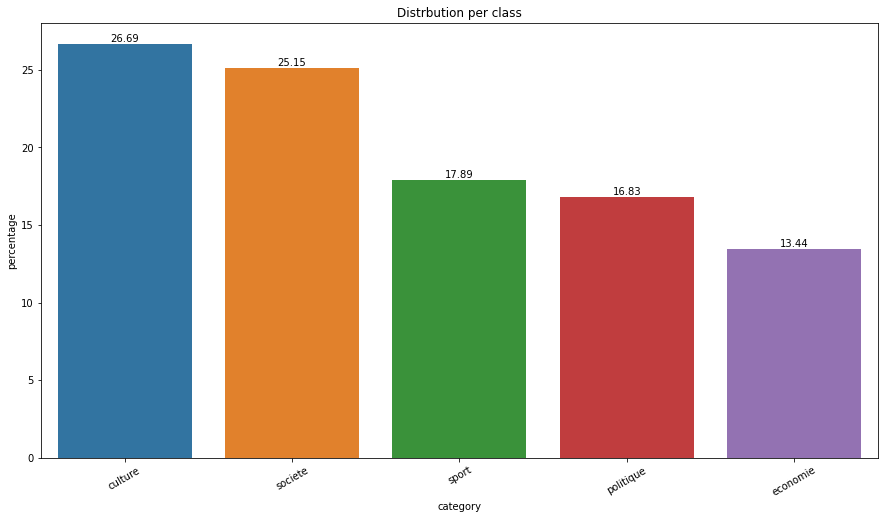

In [53]:
# Get the percentage of every class in the whole training data. 
category_percentage = (100*df.target.value_counts()/len(df)).to_frame().reset_index()
category_percentage.columns = ['category', 'percentage']


# Visualize the output
plt.figure(figsize=(15,8))
chart = sns.barplot(x='category', y='percentage', data=category_percentage)
chart.set_title('Distrbution per class')
chart.set_xticklabels(chart.get_xticklabels(), rotation=30)

for p in chart.patches:
             chart.annotate("%0.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')

#  Traitement des données

In [40]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
def netoyage(corpus_ensemble_documents):
    for i in range(len(corpus_ensemble_documents)):
        corpus_ensemble_documents[i] = corpus_ensemble_documents[i].lower()
    for i in range(len(corpus_ensemble_documents)):
        for c in string.punctuation:
             x = corpus_ensemble_documents[i].replace(c," ")
             corpus_ensemble_documents[i] = x
    stopwords_anglais = stopwords.words('french') #ou french
    for i in range(len(corpus_ensemble_documents)):
        L = corpus_ensemble_documents[i].split()
        for mot in L:
            if mot in stopwords_anglais:
                while mot in L:
                    L.remove(mot)
        corpus_ensemble_documents[i] = " ".join(L)
    return(corpus_ensemble_documents)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
df_nettoye = netoyage(df.iloc[:,0])


In [42]:
# le dataset aprés le nettoyage des données texte
df

,texte,target
0,renault group managem group scellé mercredi ca...,economie
1,s’inscrivant cadre d’un partenariat stratégiqu...,economie
2,000 tonnes sulfate cobalt an pendant période 7...,economie
3,vertu cette alliance deux groupes visent sécur...,economie
4,ainsi renault group s’assurera d’un approvisio...,economie
...,...,...
2063,gnaoua créent passerelles amènent cette croisé...,culture
2064,fusion enfin entre engagement résilience depui...,culture
2065,résilient a depuis plus 20 ans œuvré prise con...,culture
2066,gnaoua festival tour résultat cet engagement c...,culture


In [43]:
X_train, X_test, y_train, y_test = train_test_split(df_nettoye, df.iloc[:,1],shuffle=True,random_state=42, test_size=0.3)
y_train
dic = {"texte" :X_train ,"target" : y_train}
df_train = pd.DataFrame(dic)
df_train

,texte,target
1220,retour harit mazraoui encore taarabt va il per...,sport
2038,compte tenu position le marché ferons tout pos...,culture
481,,politique
1870,congrès mondial flamenco est vivier d’émotions...,culture
506,dès lors régime militaire s’est mis dos l’isla...,politique
...,...,...
1638,cette preuve donc apodictique sa forme démonst...,culture
1095,ainsi cas actifs sous traitement niveau nation...,societe
1130,311,societe
1294,mohammed rabii hrimat far 18,sport


In [44]:
def run_model(model ):
    for (i,j) in model :
#         if i != "Ridge":
#             continue
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model1 = make_pipeline(TfidfVectorizer(),j)
        print(i, "---------->" ,cross_val_score(model1,df_train.iloc[:,0],df_train.iloc[:,1] ,cv=cv ,).mean())
        y_pred = cross_val_predict(model1, X_test, y_test, cv=cv)
        print(accuracy_score(y_pred , y_test) ,y_pred , y_test)
        
#         return y_pred
        


In [45]:
models = [('LR', LogisticRegression(n_jobs=-1)),
           ('SGD', SGDClassifier(n_jobs=-1)),
           ('Ridge', RidgeClassifier()), 
           ('MultinomialNB', MultinomialNB()), 
           ('SVM', SVC()),
           ('GradientBoosting', GradientBoostingClassifier())]

print(run_model(models))


LR ----------> 0.7062761007039733
0.5829307568438004 ['culture' 'politique' 'culture' 'culture' 'culture' 'culture' 'culture'
 'culture' 'culture' 'culture' 'culture' 'societe' 'politique' 'culture'
 'sport' 'culture' 'societe' 'culture' 'societe' 'culture' 'sport'
 'politique' 'culture' 'culture' 'culture' 'culture' 'economie'
 'politique' 'societe' 'culture' 'societe' 'sport' 'culture' 'culture'
 'culture' 'politique' 'politique' 'politique' 'culture' 'societe'
 'politique' 'culture' 'culture' 'culture' 'societe' 'culture' 'sport'
 'culture' 'societe' 'culture' 'culture' 'societe' 'culture' 'culture'
 'culture' 'culture' 'politique' 'culture' 'politique' 'culture' 'sport'
 'politique' 'culture' 'societe' 'culture' 'sport' 'politique' 'culture'
 'culture' 'culture' 'culture' 'culture' 'culture' 'societe' 'culture'
 'culture' 'politique' 'culture' 'culture' 'sport' 'culture' 'culture'
 'politique' 'culture' 'culture' 'culture' 'culture' 'politique'
 'politique' 'culture' 'culture' 'cul

Ridge ----------> 0.7539577616036273
0.6586151368760065 ['culture' 'politique' 'culture' 'culture' 'culture' 'societe' 'culture'
 'culture' 'economie' 'sport' 'culture' 'societe' 'politique' 'economie'
 'sport' 'culture' 'societe' 'culture' 'societe' 'politique' 'sport'
 'politique' 'culture' 'culture' 'politique' 'culture' 'economie'
 'politique' 'societe' 'culture' 'societe' 'sport' 'culture' 'culture'
 'culture' 'politique' 'politique' 'politique' 'culture' 'societe'
 'politique' 'culture' 'sport' 'culture' 'societe' 'culture' 'sport'
 'societe' 'societe' 'societe' 'societe' 'societe' 'culture' 'culture'
 'culture' 'culture' 'politique' 'culture' 'politique' 'culture' 'sport'
 'politique' 'culture' 'societe' 'economie' 'sport' 'politique' 'culture'
 'culture' 'culture' 'culture' 'culture' 'politique' 'societe' 'culture'
 'culture' 'politique' 'culture' 'culture' 'sport' 'culture' 'culture'
 'politique' 'culture' 'culture' 'economie' 'culture' 'politique'
 'politique' 'culture' 'poli

SVM ----------> 0.644760768404725
0.46537842190016104 ['culture' 'culture' 'culture' 'culture' 'culture' 'culture' 'culture'
 'culture' 'culture' 'culture' 'culture' 'societe' 'politique' 'culture'
 'culture' 'culture' 'societe' 'culture' 'societe' 'culture' 'sport'
 'politique' 'culture' 'culture' 'culture' 'culture' 'culture' 'politique'
 'societe' 'culture' 'culture' 'culture' 'culture' 'culture' 'culture'
 'culture' 'culture' 'politique' 'culture' 'culture' 'culture' 'culture'
 'culture' 'culture' 'culture' 'culture' 'culture' 'culture' 'culture'
 'culture' 'culture' 'societe' 'culture' 'culture' 'culture' 'culture'
 'politique' 'culture' 'politique' 'culture' 'culture' 'politique'
 'culture' 'societe' 'culture' 'sport' 'politique' 'culture' 'culture'
 'culture' 'culture' 'culture' 'culture' 'societe' 'culture' 'culture'
 'politique' 'culture' 'culture' 'culture' 'culture' 'culture' 'politique'
 'culture' 'culture' 'culture' 'culture' 'politique' 'culture' 'culture'
 'culture' 'cul